# Práctica 4: Procesamieto de audio

### **Participantes:**
- Gerardo León Quintana
- Susana Suárez Mendoza

## Ejercicio 1:

Construir un identificador de notas musicales. Es decir; en su versión más sencilla (y suficiente) la entrada es un sonido con una sola nota musical y debe identificar cuál es. Por simplicidad elija un único instrumento para la identificación. 

In [1]:
from identifiers.single_notes.identifier_factory import IdentifierFactory
from identifiers.chords.identifier_chords_factory import IdentifierChordsFactory
from identifiers.scales.scales_factory import ScalesIdentifierFactory
import warnings
import os
import pandas as pd

## 1.1 Identificación de una sola nota de los diversos instrumentos

Se ha llevado a cabo la identificación de las notas y sus correspondientes octavas en los instrumentos piano, guitarra, trompeta, violín y xilófono. Se cuenta con archivos de audio que contienen la reproducción de una sola nota para cada uno de los instrumentos mencionados. Además, se dispone de un conjunto de archivos con la mayoría de las notas disponibles, las cuales han sido debidamente etiquetadas para facilitar su análisis y clasificación.

In [2]:
def get_data(files, identifier, tolerance=5):
    resultados = []
    for file in os.listdir(files):
        if file.endswith(".wav"):
            file_path = os.path.join(files, file)
            class_name, result, frecuencia = identifier.identify_note_from_audio(file_path, tolerance)
            resultados.append({
                "Archivo": file,
                "Nota Identificada": class_name,
                "Octava": result,
                "Frecuencia": frecuencia
            })
    
    return pd.DataFrame(resultados)

In [3]:
warnings.filterwarnings("ignore")

piano_files = "./audios/piano/notas"
identifier = IdentifierFactory.initialize_identifier("Piano")

df_resultados = get_data(piano_files, identifier, tolerance=6)
display(df_resultados)

,Archivo,Nota Identificada,Octava,Frecuencia
0,do_piano.wav,Do,5,523.370840
1,do_reb.wav,DoSostenidoReb,5,558.260716
2,fa_piano.wav,Fa,4,348.570527
3,fa_solb.wav,FaSostenidoSolb,5,745.862282
4,la_piano.wav,La,4,439.079029
5,la_sib.wav,LaSostenidoSib,4,469.328486
6,mi_piano.wav,Mi,4,329.206744
7,re_mib.wav,ReSostenidoMib,5,627.069595
8,re_piano.wav,Re,4,291.513399
9,si_piano.wav,Si,4,494.372433


In [4]:
warnings.filterwarnings("ignore")

guitar_files = "./audios/guitarra/notas"
identifier = IdentifierFactory.initialize_identifier("Guitar")

df_resultados = get_data(guitar_files, identifier)
display(df_resultados)

,Archivo,Nota Identificada,Octava,Frecuencia
0,do_guitar.wav,Do,4,260.343943
1,do_sostenido.wav,DoSostenidoReb,3,139.152080
2,fa_guitar.wav,Fa,3,177.094082
3,fa_sostenido.wav,FaSostenidoSolb,3,183.364479
4,la_guitar.wav,La,3,219.947094
5,la_sostenido.wav,LaSostenidoSib,3,235.309330
6,mi_guitar.wav,Mi,3,162.584992
7,re_guitar.wav,Re,4,291.719891
8,re_sostenido.wav,ReSostenidoMib,4,314.449468
9,si_guitar.wav,Si,3,246.786632


In [5]:
warnings.filterwarnings("ignore")

trumpet_files = "./audios/trompeta/notas"
identifier = IdentifierFactory.initialize_identifier("Trumpet")

df_resultados = get_data(trumpet_files, identifier)

display(df_resultados)

,Archivo,Nota Identificada,Octava,Frecuencia
0,do_sostenido.wav,DoSostenidoReb,5,554.400000
1,do_trumpet.wav,Do,4,264.678030
2,fa.wav,Fa,4,351.883409
3,fa_sostenido.wav,FaSostenidoSolb,5,743.988507
4,la.wav,La,5,879.936414
5,la_sostenido.wav,LaSostenidoSib,4,466.431825
6,mi.wav,Mi,4,325.581973
7,re.wav,Re,5,589.677419
8,re_sostenido.wav,ReSostenidoMib,4,315.279472
9,si.wav,Si,5,988.209686


In [6]:
warnings.filterwarnings("ignore")

violin_files = "./audios/violin/notas"
identifier = IdentifierFactory.initialize_identifier("Violin")

df_resultados = get_data(violin_files, identifier)

display(df_resultados)

,Archivo,Nota Identificada,Octava,Frecuencia
0,do.wav,Do,5,521.282078
1,do_sostenido.wav,DoSostenidoReb,4,275.946028
2,fa.wav,Fa,4,351.966380
3,fa_sostenido.wav,FaSostenidoSolb,4,372.756363
4,la.wav,La,4,441.454014
5,la_sostenido.wav,LaSostenidoSib,3,232.939783
6,mi.wav,Mi,6,1318.807397
7,re.wav,Re,4,294.935302
8,re_sostenido.wav,ReSostenidoMib,5,623.614461
9,si.wav,Si,4,493.200000


In [7]:
warnings.filterwarnings("ignore")

xylophone_files = "./audios/xilofono/notas"
identifier = IdentifierFactory.initialize_identifier("Xylophone")

df_resultados = get_data(xylophone_files, identifier)

display(df_resultados)

,Archivo,Nota Identificada,Octava,Frecuencia
0,do.wav,Do,6,1050.666667
1,fa.wav,Fa,6,1398.933333
2,la.wav,La,6,1761.600000
3,mi.wav,Mi,6,1319.733333
4,re.wav,Re,6,1178.133333
5,si.wav,Si,6,1978.666667
6,sol.wav,Sol,6,1570.133333


### 1.1.1 Identificación de la nota de un solo archivo de audio

Si se requeriese, se puede identificar un solo archivo de audio mediante el siguiente código.

In [8]:
archivo_audio = "./audios/violin/notas/si.wav"

identifier = IdentifierFactory.initialize_identifier("Violin")
class_name, octava, dominant_freq = identifier.identify_note_from_audio(archivo_audio)

print(f"La nota identificada es {class_name} en la octava {octava} con una frecuencia dominante de {dominant_freq} Hz")

La nota identificada es Si en la octava 4 con una frecuencia dominante de 493.20000000000005 Hz


## 1.2. Identificación de acordes triada de los diversos instrumentos

Un **acorde** es un conjunto de tres o más notas que se tocan simultáneamente, formando una combinación armónica que añade color y profundidad a la música. Los acordes se basan en intervalos, que son las distancias entre las notas, y pueden generar sensaciones diferentes dependiendo de cómo se construyan (mayores, menores, disminuidos, aumentados, etc.). Por simplicidad, se ha escodgido la identificación de **acordes triada**, los cuales son el tipo más básico de acorde, compuestos específicamente por tres notas: la tónica (nota base), la tercera (que puede ser mayor o menor) y la quinta (que puede ser justa, disminuida o aumentada). La combinación de estas tres notas define el carácter del acorde.

In [9]:
def get_data_chords(files, identifier):
    resultados_reales = []
    resultados_aproximados = [] 
    for file in os.listdir(files):
        if file.endswith(".wav"):
            file_path = os.path.join(files, file)
            identified_chord, notes_names, dominant_frequencies, real_chord = identifier.identify_chord_from_audio(file_path)
            if real_chord:
                resultados_reales.append({
                    "Archivo": file,
                    "Acorde Identificado": identified_chord,
                    "Acorde Real": "-".join(notes_names),
                    "Frecuencias": dominant_frequencies
                })
            elif not real_chord:
                for aprox_chord, approx_notes in zip(identified_chord, notes_names):
                    resultados_aproximados.append({
                        "Archivo": file,
                        "Acorde Identificado": aprox_chord,
                        "Acorde Real": "-".join(approx_notes[0]),
                        "Notas Identificadas": "-".join(approx_notes[1]),
                        "Frecuencias": dominant_frequencies
                    })

            elif real_chord == None:
                print(f"No se pudo identificar el acorde del archivo {file}")
    
    return pd.DataFrame(resultados_reales), pd.DataFrame(resultados_aproximados)

### 1.2.1. Acordes del piano

In [10]:
chords_piano_folder = "./audios/piano/acordes" 
identifier = IdentifierChordsFactory.initialize_identifier("Piano")

df_resultados, df_aproximados = get_data_chords(chords_piano_folder, identifier)
display(df_resultados)
display(df_aproximados)

,Archivo,Acorde Identificado,Acorde Real,Frecuencias
0,do_mayor.wav,Do Mayor,Do-Mi-Sol,"[392.17, 330.0, 261.5]"
1,do_menor.wav,Do Menor (Cm),Do-ReSostenidoMib-Sol,"[311.32, 261.66, 392.24]"
2,do_sostenido_mayor.wav,Do Sostenido Mayor (C#),DoSostenidoReb-Fa-SolSostenidoLab,"[415.5, 277.0, 349.33]"
3,do_sostenido_menor.wav,Do Sostenido Menor (C#m),DoSostenidoReb-Mi-SolSostenidoLab,"[415.5, 277.0, 330.0]"
4,fa_mayor.wav,Fa Mayor,Fa-La-Do,"[349.33, 523.5, 440.33]"
5,fa_menor.wav,Fa Menor (Fm),Fa-SolSostenidoLab-Do,"[415.5, 349.33, 523.5]"
6,fa_sostenido_mayor.wav,Fa Sostenido Mayor (F#),FaSostenidoSolb-LaSostenidoSib-DoSostenidoReb,"[466.33, 554.5, 370.17]"
7,fa_sostenido_menor.wav,Fa Sostenido Menor (F#m),FaSostenidoSolb-La-DoSostenidoReb,"[554.5, 370.17, 440.33]"
8,la_mayor.wav,La Mayor,La-DoSostenidoReb-Mi,"[554.5, 440.33, 660.17]"
9,la_menor.wav,La Menor (Am),La-Do-Mi,"[523.5, 440.33, 660.17]"


""


### 1.2.2. Acordes de la guitarra

In [11]:
chords_guitar_folder = "./audios/guitarra/acordes"

identifier = IdentifierChordsFactory.initialize_identifier("Guitar")
df_resultados, df_aproximados = get_data_chords(chords_guitar_folder, identifier)
display(df_resultados)
display(df_aproximados)

,Archivo,Acorde Identificado,Acorde Real,Frecuencias
0,do_mayor.wav,Do Mayor,Do-Mi-Sol,"[131.08, 329.31, 393.54]"
1,do_sostenido_mayor.wav,Do Sostenido Mayor (C#),DoSostenidoReb-Fa-SolSostenidoLab,"[349.88, 277.85, 205.89]"
2,la_menor.wav,La Menor (Am),La-Do-Mi,"[221.77, 330.51, 262.29]"
3,mi_menor.wav,Mi Menor (Em),Mi-Sol-Si,"[247.62, 164.29, 197.02]"
4,sol_mayor.wav,Sol Mayor,Sol-Si-Re,"[146.2, 123.1, 197.3]"


,Archivo,Acorde Identificado,Acorde Real,Notas Identificadas,Frecuencias
0,do_menor-sol_sost_mayor.wav,Do Menor (Cm),Do-ReSostenidoMib-Sol,ReSostenidoMib-Do,"[154.64, 130.09, 260.34]"
1,do_menor-sol_sost_mayor.wav,Sol Sostenido Mayor (G#),SolSostenidoLab-Do-ReSostenidoMib,ReSostenidoMib-Do,"[154.64, 130.09, 260.34]"
2,fa_menor-do_sost_mayor.wav,Do Sostenido Mayor (C#),DoSostenidoReb-Fa-SolSostenidoLab,SolSostenidoLab-Fa,"[415.86, 348.75, 208.13]"
3,fa_menor-do_sost_mayor.wav,Fa Menor (Fm),Fa-SolSostenidoLab-Do,SolSostenidoLab-Fa,"[415.86, 348.75, 208.13]"
4,mi_mayor-menor.wav,Mi Mayor,Mi-SolSostenidoLab-Si,Si-Mi,"[123.86, 328.6, 371.75]"
5,mi_mayor-menor.wav,Mi Menor (Em),Mi-Sol-Si,Si-Mi,"[123.86, 328.6, 371.75]"
6,mi_mayor-menor.wav,Si Mayor,Si-ReSostenidoMib-FaSostenidoSolb,Si-FaSostenidoSolb,"[123.86, 328.6, 371.75]"
7,mi_mayor-menor.wav,Si Menor (Bm),Si-Re-FaSostenidoSolb,Si-FaSostenidoSolb,"[123.86, 328.6, 371.75]"
8,re_mayor-re_menor.wav,Re Mayor,Re-FaSostenidoSolb-La,La-Re,"[220.2, 146.61, 293.1]"
9,re_mayor-re_menor.wav,Re Menor (Dm),Re-Fa-La,La-Re,"[220.2, 146.61, 293.1]"


### 1.2.3. Acordes de la trompeta

In [12]:
chords_trumpet_folder = "./audios/trompeta/acordes"

identifier = IdentifierChordsFactory.initialize_identifier("Trumpet")
df_resultados, df_aproximados = get_data_chords(chords_trumpet_folder, identifier)
display(df_resultados)
display(df_aproximados)

""


,Archivo,Acorde Identificado,Acorde Real,Notas Identificadas,Frecuencias
0,prueba.wav,Mi Menor (Em),Mi-Sol-Si,Sol-Si,"[390.7, 589.0, 492.9]"
1,prueba.wav,Sol Mayor,Sol-Si-Re,Sol-Si,"[390.7, 589.0, 492.9]"
2,prueba2.wav,Mi Menor (Em),Mi-Sol-Si,Sol-Si,"[389.18, 437.18, 489.73]"
3,prueba2.wav,Sol Mayor,Sol-Si-Re,Sol-Si,"[389.18, 437.18, 489.73]"


### 1.2.4. Acordes del violin

In [13]:
chords_violin_folder = "./audios/violin/acordes"

identifier = IdentifierChordsFactory.initialize_identifier("Violin")
df_resultados, df_aproximados = get_data_chords(chords_violin_folder, identifier)
display(df_resultados)
display(df_aproximados)

,Archivo,Acorde Identificado,Acorde Real,Frecuencias
0,sol_mayor.wav,Sol Mayor,Sol-Si-Re,"[293.64, 390.92, 496.83]"


""


### 1.2.5. Acordes del Xilófono

In [14]:
chords_xylophone_folder = "./audios/xilofono/acordes"

identifier = IdentifierChordsFactory.initialize_identifier("Xylophone")
df_resultados, df_aproximados = get_data_chords(chords_xylophone_folder, identifier)
display(df_resultados)
display(df_aproximados)

""


,Archivo,Acorde Identificado,Acorde Real,Notas Identificadas,Frecuencias
0,prueba.wav,Do Mayor,Do-Mi-Sol,Mi-Sol,"[1319.44, 1568.97, 2091.81]"
1,prueba.wav,Mi Menor (Em),Mi-Sol-Si,Mi-Sol,"[1319.44, 1568.97, 2091.81]"


## 1.3. Aproximación de la partitura de un audio

Una **partitura** es una representación gráfica de una pieza musical que indica qué notas deben tocarse, su duración y otros detalles interpretativos. En otras palabras, es el lenguaje escrito de la música. La partitura de un sonido o audio es, por lo tanto, la transcripción de los elementos musicales de ese sonido en un formato legible para los músicos, usando símbolos convencionales como notas, silencios, claves, compases y otros signos.

### 1.3.1. Escalas para un piano

In [15]:
archivo_audio = "./audios/piano/sonidos_completos/c3_major_scale.wav"

scale_identifier = ScalesIdentifierFactory.initialize_identifier("Piano")
notas_identificadas, octavas_identificadas, frecuencias_identificadas, time_stamps = scale_identifier.identify_scale_from_audio(archivo_audio, timestep=0.1)

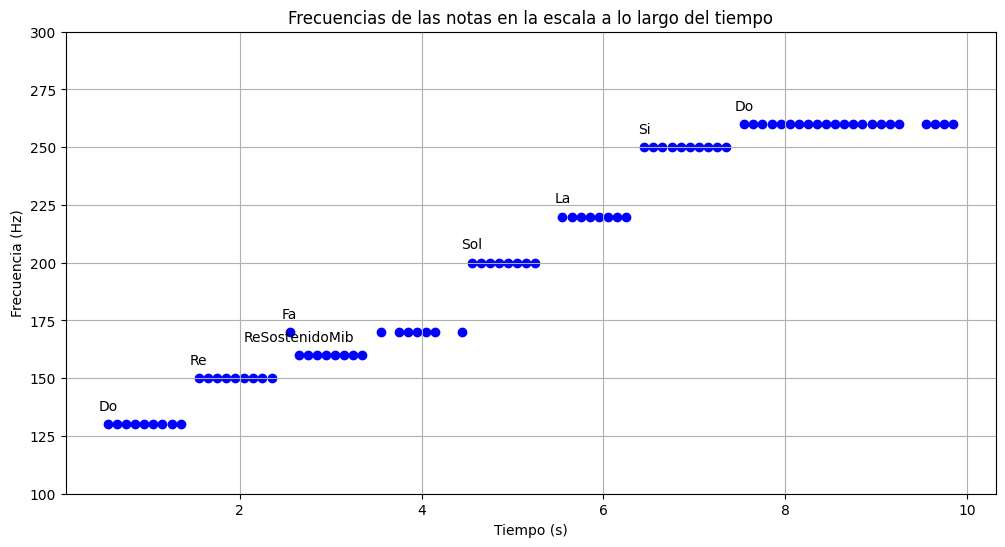

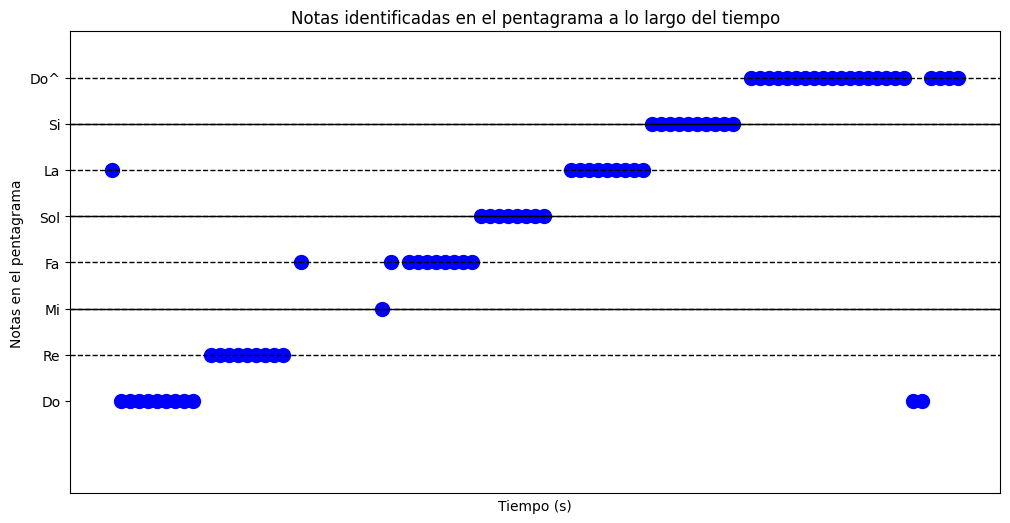

In [16]:
scale_identifier.plot_scale_over_time(notas_identificadas, frecuencias_identificadas, time_stamps, min_scale=100, max_scale=300)
scale_identifier.plot_notes_on_staff(notas_identificadas,octavas_identificadas, time_stamps, start=3)

In [17]:
archivo_audio = "./audios/piano/sonidos_completos/c4_mayor_scale.wav"

scale_identifier = ScalesIdentifierFactory.initialize_identifier("Piano")
notas_identificadas, octavas_identificadas, frecuencias_identificadas, time_stamps = scale_identifier.identify_scale_from_audio(archivo_audio, timestep=0.1)

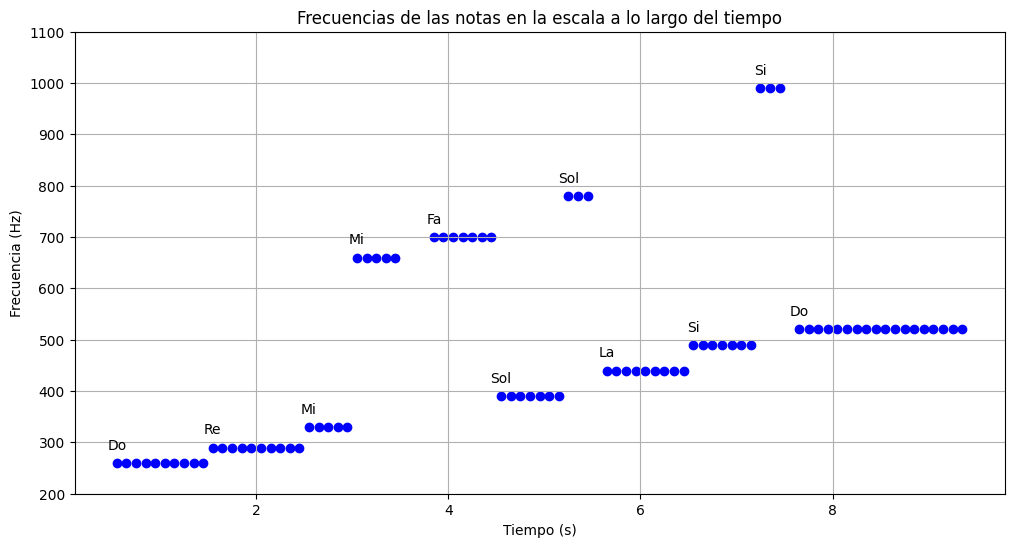

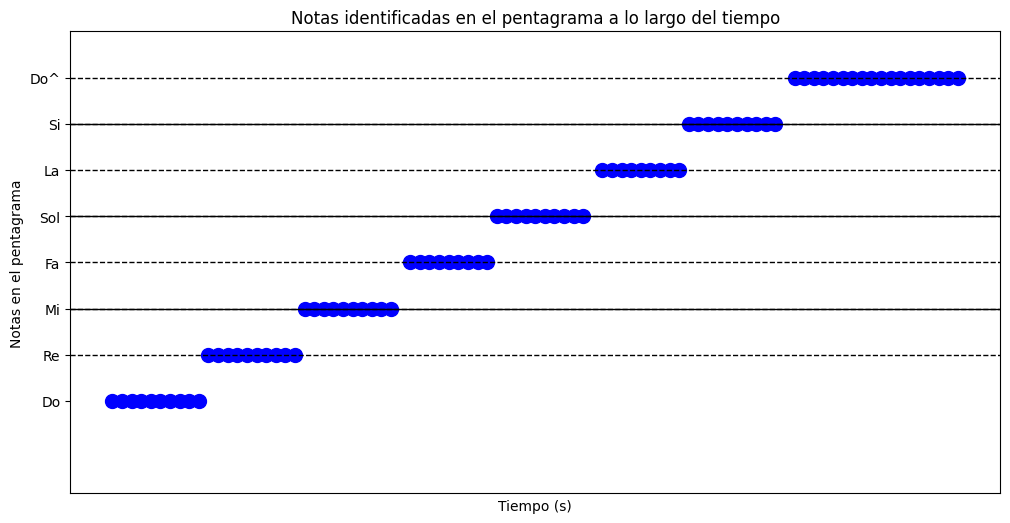

In [18]:
scale_identifier.plot_scale_over_time(notas_identificadas, frecuencias_identificadas, time_stamps, min_scale=200, max_scale=1100)
scale_identifier.plot_notes_on_staff(notas_identificadas,octavas_identificadas, time_stamps)

In [19]:
archivo_audio = "./audios/piano/sonidos_completos/prueba.wav"

scale_identifier = ScalesIdentifierFactory.initialize_identifier("Piano")
notas_identificadas, octavas_identificadas, frecuencias_identificadas, time_stamps = scale_identifier.identify_scale_from_audio(archivo_audio, timestep=0.1)
print(octavas_identificadas)

[['D#4'], ['D4'], ['D4'], ['D4'], ['D4'], ['D4'], ['E4'], ['E4'], ['E4'], ['E4'], ['E4'], ['D5'], ['D5'], ['D5'], ['D5'], ['E4'], ['E4'], ['E4'], ['E4'], ['F#4'], ['F#5'], ['F#4'], ['F#4'], ['F#4'], ['F#4'], ['F#4'], ['F#4'], ['D4'], ['D4'], ['D4'], ['F#4'], ['F#4'], ['D4'], ['A#2'], ['A#2'], ['D5'], ['D5'], ['D5'], ['D5'], ['F#4'], ['F#4'], ['A#2'], ['F#4'], ['A3'], ['A3'], ['F#4'], ['F#4'], ['F#4'], ['A#2'], ['A#2'], ['A#2'], ['E4'], ['E4'], ['E4'], ['E4'], ['E4'], ['E4'], ['E4'], ['E4'], ['E4'], ['E4'], ['E4'], ['E4'], ['A4'], ['A4'], ['A4'], ['A4'], ['B4'], ['B4'], ['B4'], ['B4'], ['A4'], ['A4'], ['A4'], ['A4'], ['A4'], ['A5'], ['A5'], ['A5'], ['A5'], ['A2'], ['A2'], ['A2'], ['A2'], ['A2'], ['A4'], ['A4'], ['A4'], ['C#3'], ['B4'], ['B4'], ['B4'], ['B4'], ['A4'], ['A4'], ['A4'], ['A4'], ['G4'], ['G4'], ['G4'], ['G4'], ['G4'], ['A3'], ['A3'], ['D4'], ['D4'], ['D5'], ['D5'], ['D5'], ['D5'], ['G4'], ['G4'], ['G4'], ['G4'], ['D5'], ['D5'], ['D5'], ['D5'], ['A4'], ['A4'], ['A4'], ['A4'],

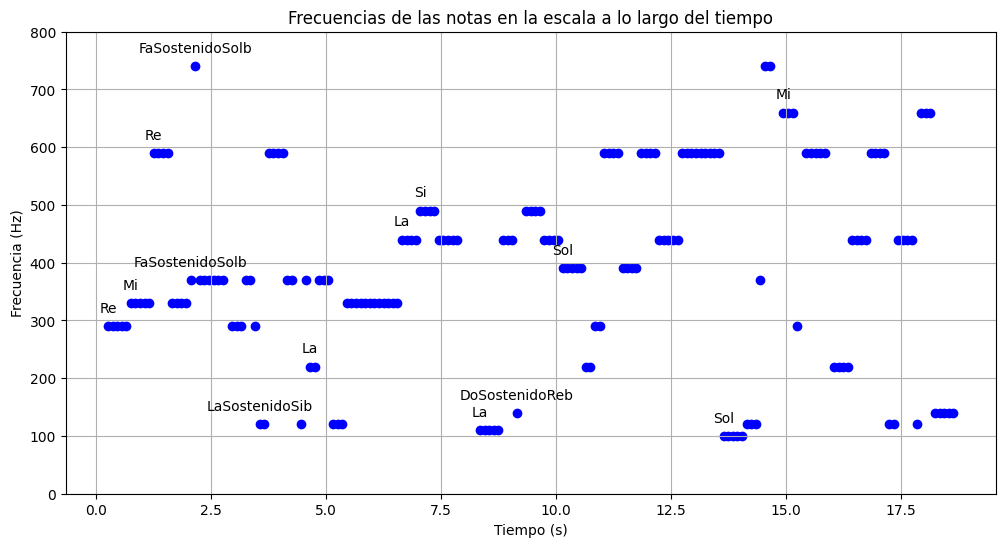

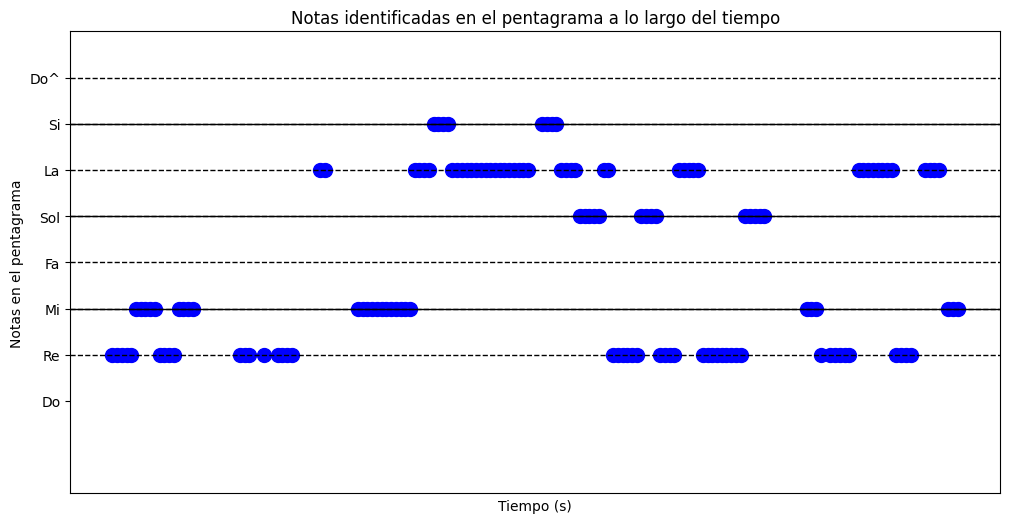

In [20]:
scale_identifier.plot_scale_over_time(notas_identificadas, frecuencias_identificadas, time_stamps, min_scale=0, max_scale=800)
scale_identifier.plot_notes_on_staff(notas_identificadas,octavas_identificadas, time_stamps)

### 1.3.2. Escalas para una guitarra

In [28]:
archivo_audio = "./audios/guitarra/sonidos_completos/prueba_lento.wav"

scale_identifier = ScalesIdentifierFactory.initialize_identifier("Guitar")
notas_identificadas, octavas_identificadas, frecuencias_identificadas, time_stamps = scale_identifier.identify_scale_from_audio(archivo_audio, timestep=0.15)

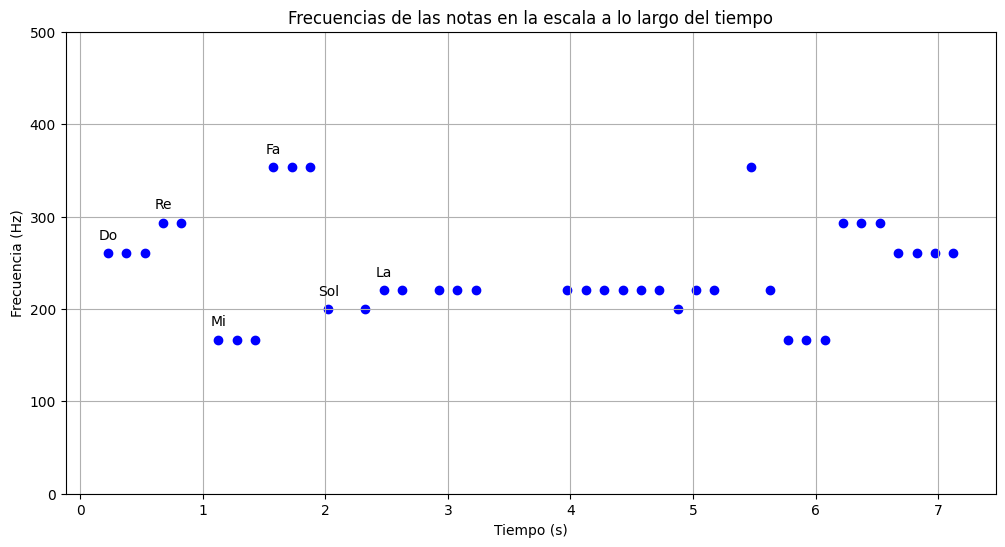

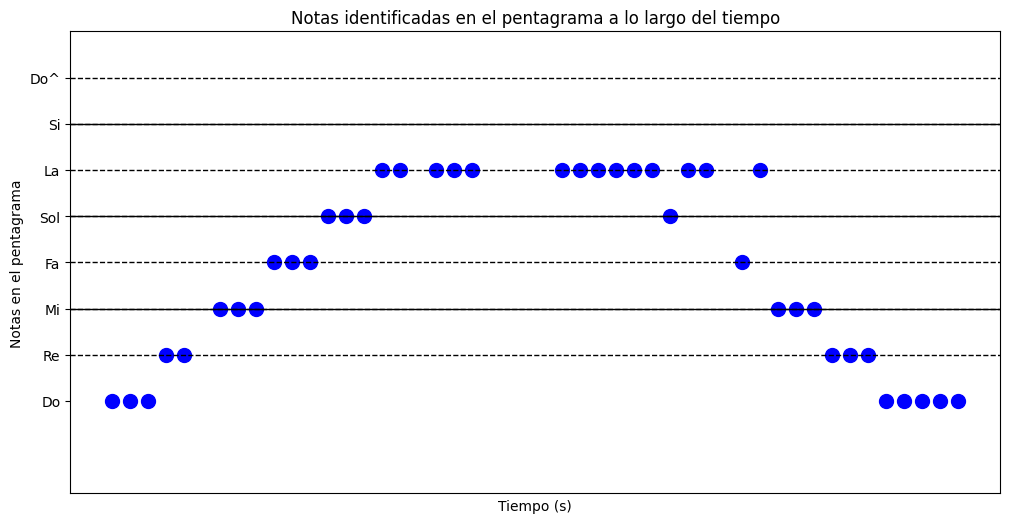

In [27]:
scale_identifier.plot_scale_over_time(notas_identificadas, frecuencias_identificadas, time_stamps, min_scale=0, max_scale=500)
scale_identifier.plot_notes_on_staff(notas_identificadas,octavas_identificadas, time_stamps, start=4)

## Cosas a mejorar
- presentación
- pentagrama

## Ejercicio 2:

Construir una pequeña aplicación que permita operar con diferentes filtros (con un selector) y trabajar con varios umbrales. (uno para los filtros pasa-bajo y pasa-alto y dos para los filtros pasa-banda y rechaza-banda). Demuestre su funcionalidad con señales ruidosas. Muestre en cada filtrado la señal original y filtrada en el dominio temporal y en el dominio de la frecuencia.